# Imports and Paths

In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from collections import Counter, deque
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import itertools
import math
import tifffile as tiff
import tensorflow as tf
import cv2

import random
random.seed(42)

In [2]:
from tensorflow.keras.models import load_model

In [3]:
# Define base path for all operations
BASE_PATH = os.path.dirname(os.getcwd())
BASE_PATH

'/home/gadmicha/Regression'

In [4]:
all_organelles = ["Nucleolus-(Granular-Component)", "Nuclear-envelope", "Mitochondria", "Actin-filaments",
                 "Endoplasmic-reticulum", "Plasma-membrane", "Microtubules", "DNA"]

In [5]:
# Define paths
organelle = all_organelles[0]
unet_model_path = f"{BASE_PATH}/models/unet/{organelle}/"
mg_model_path = f"{BASE_PATH}/models/mg/{organelle}/"
train_csv_path = f"{BASE_PATH}/data/{organelle}/image_list_train.csv"
test_csv_path = f"{BASE_PATH}/data/{organelle}/image_list_test.csv"

In [6]:
input_channel=0
if organelle == "DNA":
    target_channel=1
else:
    target_channel=3

In [7]:
# Load neccessary models
unet = load_model(unet_model_path)
mg = load_model(mg_model_path)

2025-11-12 09:49:18.075375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-11-12 09:49:18.262728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-11-12 09:49:18.264551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-11-12 09:49:18.273876: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# EDA

In [15]:
image = tiff.imread(f"/sise/assafzar-group/assafzar/full_cells_fovs/{organelle}/{organelle}_1.tiff")
print("Image shape: ", image.shape) # (Channels, Z-stacks, height, width)

Image shape:  (7, 65, 624, 924)


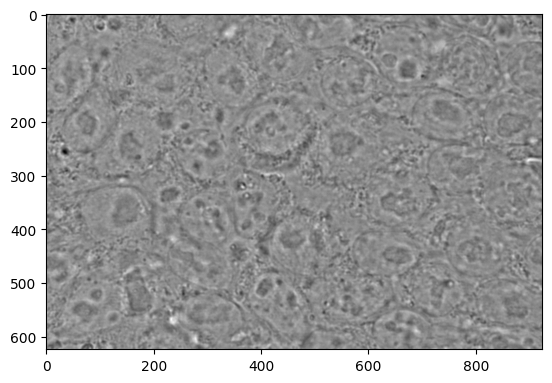

In [17]:
# Inspect input image (channel 0)
plt.imshow(image[0, 32, :, :], cmap='gray')

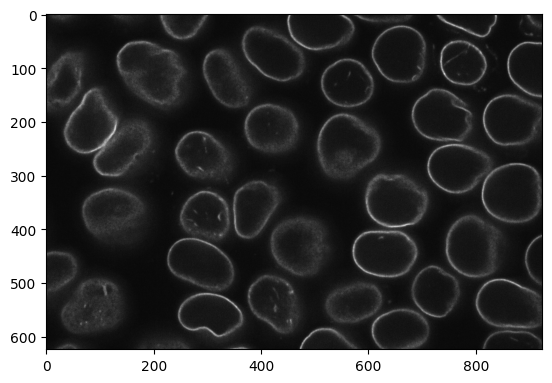

In [16]:
# Inspect target image (channel 3)
plt.imshow(image[3, 32, :, :], cmap='gray')

# Data Class

## Functions

In [7]:
def tf_pearson_corr_aux(x,y):
    mean_x = tf.reduce_mean(x)
    mean_y = tf.reduce_mean(y)
    std_x = tf.math.reduce_std(x-mean_x)
    std_y = tf.math.reduce_std(y-mean_y)
    cc = tf.reduce_mean((x - mean_x) * (y - mean_y)) / (std_x * std_y)
    return cc

def tf_pearson_corr(y_true, y_pred, weights=None):    
    if weights is not None:
        ind = tf.where(tf.logical_or(tf.reshape(weights,[-1])==1.0,tf.reshape(weights,[-1])==255.0))
        non_ind = tf.where(tf.logical_and(tf.reshape(weights,[-1])!=1.0,tf.reshape(weights,[-1])!=255.0))    
        cc = 0
        t_weights = [1.0,0.0]
        t = [ind,non_ind]
        for i in range(2):
            [x,y] = tf.cond(tf.shape(ind)[0]>0, lambda: [tf.gather(tf.reshape(y_true,[-1]), t[i]),tf.gather(tf.reshape(y_pred,[-1]), t[i])], lambda: [y_true,y_pred])       
            cc = cc + t_weights[i]*tf_pearson_corr_aux(x,y)
    else:
        x = y_true
        y = y_pred
        cc = tf_pearson_corr_aux(x,y)
    return cc

In [8]:
# Helper Functions
def get_random_patch(image, gt, patch_size=(32, 128, 128)):
    # Ensure the images are large enough for the patch size
    assert image.shape[0] >= patch_size[0], "Patch size is too large for the given z-dimension."
    assert image.shape[1] >= patch_size[1] and image.shape[2] >= patch_size[2], "Patch size is too large for the given image dimensions."
    
    # Calculate the maximum starting points for the random patch along each axis
    max_z = image.shape[0] - patch_size[0]  # z-axis (depth)
    max_x = image.shape[1] - patch_size[1]  # x-axis (height)
    max_y = image.shape[2] - patch_size[2]  # y-axis (width)
    
    # Generate random start points along each axis
    start_z = np.random.randint(0, max_z)
    start_x = np.random.randint(0, max_x)
    start_y = np.random.randint(0, max_y)

    # Extract the 3D patch from the image and the ground truth (gt)
    patch = image[start_z:start_z + patch_size[0], start_x:start_x + patch_size[1], start_y:start_y + patch_size[2]]
    gt_patch = gt[start_z:start_z + patch_size[0], start_x:start_x + patch_size[1], start_y:start_y + patch_size[2]]
    
    return patch, gt_patch

def get_patch(image, gt, sx, sy, patch_size=(32, 128, 128)):
    # Ensure the images are large enough for the patch size
    assert image.shape[0] >= patch_size[0], "Patch size is too large for the given z-dimension."
    assert image.shape[1] >= patch_size[1] and image.shape[2] >= patch_size[2], "Patch size is too large for the given image dimensions."

    # Extract the 3D patch from the image and the ground truth (gt)
    patch = image[16:48, sx:sx + patch_size[1], sy:sy + patch_size[2]]
    gt_patch = gt[16:48, sx:sx + patch_size[1], sy:sy + patch_size[2]]
    
    return patch, gt_patch

def calculate_iou(i1, i2):
    tp = np.logical_and(i1, i2)
    fp = np.subtract(np.logical_or(i1, i2), i1)
    fn = np.subtract(np.logical_or(i1, i2), i2)
    if float((tp.sum() + fp.sum() + fn.sum())) == 0:
        return 0
    iou_score = float(tp.sum()) / float((tp.sum() + fp.sum() + fn.sum()))
    return float(iou_score)

def calculate_pcc(image1, image2):
    if image1.shape != image2.shape:
        raise ValueError("Images must have the same dimensions for correlation calculation.")
    
    # Flatten the images to 1D arrays
    image1_flat = image1.ravel()
    image2_flat = image2.ravel()
    
    # Compute the Pearson correlation coefficient matrix
    correlation_matrix = np.corrcoef(image1_flat, image2_flat)
    
    # The Pearson correlation coefficient is in position [0, 1] of the matrix
    pcc = correlation_matrix[0, 1]
    return pcc

In [9]:
# Create fixed indices for test and validation
indices = {}
i = 0
for x in range(0, 496, 96):
    for y in range(0, 796, 96):
        indices[i] = (x,y)
        i += 1

len(indices)

54

In [10]:
# Transformation functions-make into a class
def normalize_std(input_image):
    # Ensure input is a numpy array and convert to float64 for precision
    input_image = np.array(input_image, dtype=np.float64)
    
    # Calculate mean and standard deviation
    mean = np.mean(input_image)
    std = np.std(input_image)

    if (np.isnan(mean) or np.isnan(std) or np.isinf(mean) or np.isinf(std)):
        max_val = np.max(input_image[np.isfinite(input_image)])
        input_image = np.where(input_image==np.inf, max_val, input_image)
        mean = np.mean(input_image,dtype=np.float64)
        std = np.std(input_image,dtype=np.float64)
    
    # Check and adjust standard deviation to avoid division by zero
    if std == 0:
        std = 1  # Prevent division by zero; alternatively could use a very small number
    
    # Normalize the image
    normalized_image = (input_image - mean) / std
    
    # Replace NaN values that might result from zero divisions or infinite values in input
    normalized_image = np.nan_to_num(normalized_image, nan=0.0)
    
    return normalized_image
    
def normalize_other(image_ndarray,max_value=255,dtype=np.uint8) -> np.ndarray:
    image_ndarray = image_ndarray.astype(np.float64)
    max_var = np.max(image_ndarray!=np.inf)
    image_ndarray = np.where(image_ndarray==np.inf,max_var,image_ndarray)
    temp_image = image_ndarray-np.min(image_ndarray)
    return ((temp_image)/((np.max(temp_image))*max_value)).astype(dtype)

def slice_image(image_ndarray: np.ndarray, indexes: list) -> np.ndarray:
    n_dim = len(image_ndarray.shape)
    slices = [slice(None)] * n_dim
    for i in range(len(indexes)):
        slices[i] = slice(indexes[i][0], indexes[i][1])
    slices = tuple(slices)
    sliced_image = image_ndarray[slices]
    return sliced_image

def mask_image_func(image_ndarray, mask_template_ndarray) -> np.ndarray:
    mask_ndarray = mask_template_ndarray
    return np.where(mask_ndarray == 255, image_ndarray, np.zeros(image_ndarray.shape))

def resize_image(patch_size, image):
    # only donwsampling, so use nearest neighbor that is faster to run
    resized_image = np.zeros(patch_size)
    for i in range(image.shape[0]):
        resized_image[i] = tf.image.resize(
            image[i], (patch_size[1], patch_size[2]
                       ), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
        )
    # resized_image = tf.cast(resized_image, tf.float16)  # / 127.5 - 1.0
    return resized_image

def augment_image(image_ndarray):
    image = np.rot90(image_ndarray, axes=(2, 3), k=np.random.random_integers(0, 3))
    return image

def dilate_image(image):
    for h in range(image.shape[1]):
        image[0, h, :, :] = cv2.dilate(image[0, h, :, :].astype(np.uint8), self.dilate_kernel)   
    return image


In [11]:
# Transformations
class Transpose:
    def __init__(self):
        pass
    
    def __call__(self, image):
        image = image.transpose(0, 4, 1, 2, 3) # PyTorch expects the input tensor format for CNNs as (batch_size, channels, height, width).
        return image

train_transforms = transforms.Compose([
    # transforms.RandomHorizontalFlip(), # Flip the image horizontally
    # transforms.RandomRotation(degrees=10), # Rotate the image by up to 10 degrees
    # Transpose(),
    transforms.ToTensor(), # Convert to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize values
])

test_transforms = transforms.Compose([
    # Transpose(),
    transforms.ToTensor(), # Convert to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize values
])

## Classes

In [12]:
class RegressionDataset(Dataset):
  """
  This class inherits from pytorch Dataset and defines basic functions that are
  needed for using pycharm operations on our data.
  """
  def __init__(self, csv_path, transform=None, min_=0.0, max_=1.0):
    self.df = pd.read_csv(csv_path) # CSV with image locations
    self.transform = transform # list of transformations on the data
    self.min_ = min_
    self.max_ = max_
    self.patches_from_image = 32

  def __len__(self):
    # Total patches for selected images
    num_selected_images = math.ceil((self.max_ - self.min_) * len(self.df))
    return num_selected_images * self.patches_from_image

  def __getitem__(self, index):
    if index >= len(self):
        raise IndexError("Index out of range")

    num_selected_images = math.ceil((self.max_ - self.min_) * len(self.df))
    start_idx = math.floor(len(self.df) * self.min_)
    image_idx = start_idx + (index // self.patches_from_image) % num_selected_images
    image = np.array(tiff.imread(self.df.loc[image_idx, 'path_tiff']))
    input_image = image[input_channel, :, :, :]
    target_image = image[target_channel, :, :, :]
      
    input_image = normalize_std(input_image)

    input_patch, target_patch = get_random_patch(input_image, target_image)
                                                
    input_patch = np.expand_dims(input_patch, axis=-1)
    input_patch = np.expand_dims(input_patch, axis=0)
    target_patch = np.expand_dims(target_patch, axis=-1)
    target_patch = np.expand_dims(target_patch, axis=0)
    
    target_prediction = unet(input_patch)
    mask_prediction = mg.generator([input_patch, target_prediction]) # Check if casting is needed
    error_rate = 1 - abs(tf_pearson_corr(target_prediction, tf.cast(target_patch, tf.float64)))
    error_rate = tf.where(tf.math.is_nan(error_rate), tf.zeros_like(error_rate), error_rate)

    mask_prediction = mask_prediction.numpy()
    combined_input = np.concatenate([target_prediction, mask_prediction], axis=-1)

    combined_input = torch.from_numpy(combined_input).float()
    combined_input = combined_input.permute(0, 4, 1, 2, 3)
    combined_input = combined_input.squeeze(0)
    error_rate = torch.tensor([error_rate.numpy()], dtype=torch.float32)

    return combined_input, error_rate

In [13]:
class RegressionTestDataset(Dataset):
  """
  This class inherits from pytorch Dataset and defines basic functions that are
  needed for using pycharm operations on our data.
  """
  def __init__(self, csv_path, indices, transform=None, min_=0.0, max_=1.0):
    self.df = pd.read_csv(csv_path) # CSV with image locations
    self.indices = indices
    self.transform = transform # list of transformations on the data
    self.min_ = min_
    self.max_ = max_
    self.patches_from_image = 54 # Patches from test image

  def __len__(self):
    # Total patches for selected images
    num_selected_images = math.ceil((self.max_ - self.min_) * len(self.df))
    return num_selected_images * self.patches_from_image

  def __getitem__(self, index):
    if index >= len(self):
        raise IndexError("Index out of range")

    # Calculate which image and patch to access directly
    num_selected_images = math.ceil((self.max_ - self.min_) * len(self.df))
    start_idx = math.floor(len(self.df) * self.min_)

    # Compute image index and patch index from the given dataset index
    image_idx = start_idx + (index // self.patches_from_image) % num_selected_images
    patch_idx = index % self.patches_from_image
      
    # Load the correct image
    image = np.array(tiff.imread(self.df.loc[image_idx, 'path_tiff']))
    input_image = image[input_channel, :, :, :]
    target_image = image[target_channel, :, :, :]
      
    # Apply normalization
    input_image = normalize_std(input_image)

    # Access the specific patch
    sx, sy = self.indices[patch_idx]  # Directly map to the correct indices
    input_patch, target_patch = get_patch(input_image, target_image, sx, sy)
                                                
    input_patch = np.expand_dims(input_patch, axis=-1)
    input_patch = np.expand_dims(input_patch, axis=0)
    target_patch = np.expand_dims(target_patch, axis=-1)
    target_patch = np.expand_dims(target_patch, axis=0)
    
    target_prediction = unet(input_patch)
    mask_prediction = mg.generator([input_patch, target_prediction]) # Check if casting is needed
    error_rate = 1 - abs(tf_pearson_corr(target_prediction, tf.cast(target_patch, tf.float64)))
    error_rate = tf.where(tf.math.is_nan(error_rate), tf.zeros_like(error_rate), error_rate)

    mask_prediction = mask_prediction.numpy()
    combined_input = np.concatenate([target_prediction, mask_prediction], axis=-1)

    combined_input = torch.from_numpy(combined_input).float()
    combined_input = combined_input.permute(0, 4, 1, 2, 3)
    combined_input = combined_input.squeeze(0)
    error_rate = torch.tensor([error_rate.numpy()], dtype=torch.float32)

    return combined_input, error_rate, input_patch, target_patch

## Check Pipeline

In [14]:
# Test pipeline
df = pd.read_csv(f"{BASE_PATH}/Samples/image_list_DNA.csv")
image = np.array(tiff.imread(df.loc[0,'path_tiff']))
input_image = image[0, :, :, :]
target_image = image[target_channel, :, :, :]

input_image = normalize_std(input_image)

input_patch, target_patch = get_random_patch(input_image, target_image)

input_patch = np.expand_dims(input_patch, axis=-1)
input_patch = np.expand_dims(input_patch, axis=0)
target_patch = np.expand_dims(target_patch, axis=-1)
target_patch = np.expand_dims(target_patch, axis=0)

target_prediction = unet(input_patch)

mask_prediction = mg.generator([input_patch, target_prediction])

error_rate = 1 - abs(tf_pearson_corr(target_prediction, tf.cast(target_patch, tf.float64)))
print(error_rate)

2025-09-09 09:29:04.814273: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8700
2025-09-09 09:29:05.122458: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


tf.Tensor(0.2909160684183054, shape=(), dtype=float64)


Text(0.5, 1.0, 'MASK')

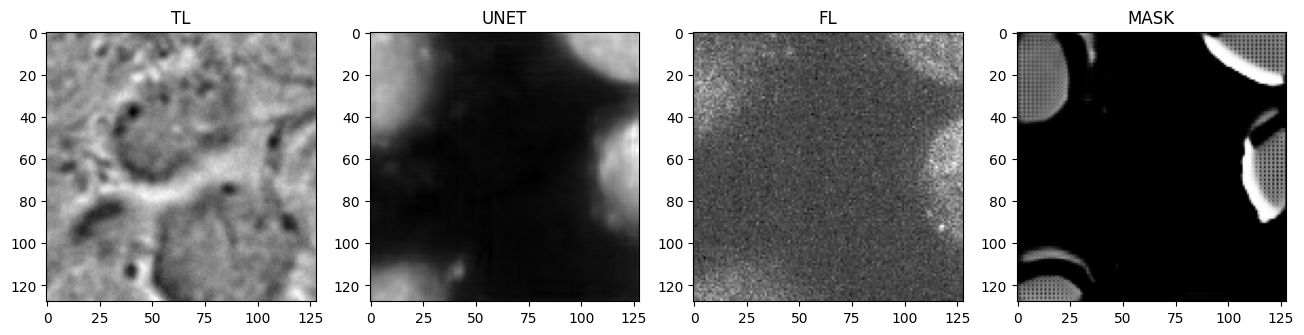

In [15]:
# Test pipeline
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 5))
zs = 16
ax1.imshow(input_patch[0,zs,:,:,0], cmap='gray')
ax1.set_title('TL')
ax2.imshow(target_prediction[0,zs,:,:,0], cmap='gray')
ax2.set_title('UNET')
ax3.imshow(target_patch[0,zs,:,:,0], cmap='gray')
ax3.set_title('FL')
ax4.imshow(mask_prediction[0,zs,:,:,0], cmap='gray')
ax4.set_title('MASK')

# Model Class

In [16]:
from torchvision.models.video import r3d_18

class ResNet3DRegression(nn.Module):
    def __init__(self, fine_tune_layers='partial'):
        super(ResNet3DRegression, self).__init__()
        # Load pretrained 3D ResNet
        self.resnet3d = r3d_18(pretrained=True)
        
        # Adjust the first convolutional layer for single-channel input
        self.resnet3d.stem[0] = nn.Conv3d(
            in_channels=2,
            out_channels=64,
            kernel_size=(3, 7, 7),
            stride=(1, 2, 2),
            padding=(1, 3, 3),
            bias=False
        )
        
        self.resnet3d.fc = nn.Identity()  # Remove the classification head

        # Fully connected layers for regression
        self.fc1 = nn.Linear(512, 128)  # ResNet3D outputs 512 features
        self.fc2 = nn.Linear(128, 1)

        # Fine-tuning options
        if fine_tune_layers == 'fc_only':  # Train only fc1 and fc2
            for param in self.resnet3d.parameters():
                param.requires_grad = False
        elif fine_tune_layers == 'partial':  # Train fc1, fc2, and later layers (e.g., layer4)
            for name, param in self.resnet3d.named_parameters():
                if 'layer4' in name or 'fc' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        elif fine_tune_layers == 'full':  # Train all layers
            for param in self.resnet3d.parameters():
                param.requires_grad = True

    def forward(self, x):
        x = self.resnet3d(x)  # Pass through 3D ResNet
        x = torch.relu(self.fc1(x))  # Fully connected layer 1
        # x = torch.nn.functional.softplus(self.fc2(x))  # Output layer
        x = torch.relu(self.fc2(x))  # Output layer
        return x


# Training

In [17]:
learning_rates = [1e-5]
batch_sizes = [16] # 8, 16, 32, 64
# momentums = [0.5, 0.7, 0.9]
weight_decays = [0.01]
optimizers = []
use_batch_norms = [True]
use_dropouts = [False]

# Trying two optimizers
for lr in learning_rates:
    for wd in weight_decays:
        optimizers.append(('adam',lr,wd))
    # for momentum in momentums:
    #     optimizers.append(('sgd',lr,momentum))

# grid_search_params = list(itertools.product(learning_rates, batch_sizes, optimizers, use_batch_norms, use_dropouts))
grid_search_params = list(itertools.product(batch_sizes, optimizers, use_batch_norms, use_dropouts))

len(grid_search_params)

1

In [18]:
# Load data
train_data = RegressionDataset(train_csv_path, transform=train_transforms, max_=0.9)
val_data = RegressionTestDataset(train_csv_path, transform=test_transforms, indices=indices, min_=0.9)
test_data = RegressionTestDataset(test_csv_path, transform=test_transforms, indices=indices)

# Data size
print(f"Train data length in patches: {len(train_data)}")
print(f"Validation data length in patches: {len(val_data)}")
print(f"Test data length in patches: {len(test_data)}")

Train data length in patches: 4000
Validation data length in patches: 756
Test data length in patches: 810


In [19]:
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is not available")
    device = torch.device("cpu")  # Fallback to CPU if GPU is not available

GPU is available


In [ ]:
def plot_costs(path, costs, val_costs):
    """
    Plotting train and validation losses through training
    """
    plt.figure(figsize=(10, 6))

    plt.plot(costs, label='Training Cost')
    plt.plot(val_costs, label='Validation Cost')

    plt.xlabel('Iteration (per epochs)')
    plt.ylabel('Cost')
    plt.title('Train cost reduction over iterations')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.savefig(f'{path}/costs_plot.pdf')
    plt.close()


number_of_epochs = 100 # 200
patience = 20  # Number of epochs to wait for improvement

loss_fn = nn.MSELoss()
top_5_loss = []
model = None

for params in grid_search_params:
    # lr, batch_size, optimizer, use_batchnorm, use_dropout = params
    batch_size, optimizer, use_batchnorm, use_dropout = params
    lr = optimizer[1]

    if optimizer[0] == 'adam':
        params_text = f"best_lr_{lr}_batch_size_{batch_size}_optimizer_{optimizer[0]}_weight_decay_{optimizer[2]}_use_batchnorm_{use_batchnorm}_use_dropout_{use_dropout}"
    elif optimizer[0] == 'sgd':
        params_text = f"best_lr_{lr}_batch_size_{batch_size}_optimizer_{optimizer[0]}_momentum_{optimizer[2]}_use_batchnorm_{use_batchnorm}_use_dropout_{use_dropout}"

    path = f"{BASE_PATH}/ISL/experiments_Mask_Pred/{organelle}/{params_text}"
    if not os.path.exists(path):
        os.makedirs(path)
    else:
        print(path)
        continue

    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []
    total_epochs = 0
    output_txt = ''

    # Using DataLoader for training with the data in Pytorch models
    train_dataLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    validation_dataLoader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    print("Finished with dataLoaders")

    # Create model
    model = ResNet3DRegression()
    print("Model created")

    # Load existing model if necessary
    # model = ResNet3DRegression(use_batchnorm=use_batchnorm, use_dropout=use_dropout)
    # model.load_state_dict(torch.load(f"{BASE_PATH}/ISL/experiments_Mask_Pred/{organelle}/{params_text}/model.pt", weights_only=True))
    # print("Model loaded")

    if optimizer[0] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=optimizer[1], momentum=optimizer[2])
    elif optimizer[0] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=optimizer[1], weight_decay=optimizer[2])
    optimizer.zero_grad()

    convergence_time = time.time()
    model.train()

    for epoch in range(number_of_epochs):
        print(f"Starting epoch {total_epochs+1}")
        total_epochs += 1
        time_start = time.time()
        model.train()
        total_loss = 0.0

        # Train
        for batch_id, (img, error_rate) in enumerate(train_dataLoader, 1):
            # (img, error_rate) = (img.to(device), error_rate.to(device))

            optimizer.zero_grad()
            for param_group in optimizer.param_groups:
              param_group['lr'] = lr
            output = model(img)
            # output = output.to(device)
            loss = loss_fn(output, error_rate)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            print(f"Batch {batch_id} finished, loss equals {loss.item()}")
            if batch_id % 1 == 0:
                print(f"output is {output}, error is {error_rate}")

        # Calculate train loss
        avg_train_loss = total_loss / len(train_dataLoader)  # Average loss for the epoch
        train_losses.append(avg_train_loss)

        # Validate
        print("Starting validation")
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for img, error_rate, ip, tp in validation_dataLoader:
                # (img, error_rate) = (img.to(device), error_rate.to(device))
                output = model(img)
                loss = loss_fn(output, error_rate)
                total_val_loss += loss.item()

        # Calculate validation loss
        avg_val_loss = total_val_loss / len(validation_dataLoader)  # Average validation loss
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{number_of_epochs}, Time: {time.time() - time_start:.2f} seconds, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
        output_txt += f"Epoch {epoch + 1}/{number_of_epochs}, Time: {time.time() - time_start:.2f} seconds, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}\n"

        # Save at end of epoch
        torch.save(model.state_dict(), f"{path}/model.pt")
        print("model saved")

        # Check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after epoch {epoch + 1}")
            output_txt += f"Early stopping triggered after epoch {epoch + 1}\n"
            torch.save(model.state_dict(), f'{path}/model.pt')
            print("model saved")
            break

        # Decay learning rate
        lr = lr * 0.99


    convergence_time = time.time() - convergence_time

    plot_costs(path, train_losses, val_losses)


    ### TEST ###
    test_dataLoader = DataLoader(test_data, batch_size=16, shuffle=True)
    
    model.eval()
    test_loss_val = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for img, error_rate, ip, tp in test_dataLoader:
            # (img, error_rate) = (img.to(device), error_rate.to(device))
            output = model(img)
            loss = loss_fn(output, error_rate)
            test_loss_val += loss.item()

    avg_test_loss = test_loss_val / len(test_dataLoader)  # Average test loss

    print(f"Test Loss: {avg_test_loss:.4f}")
    output_txt += f"Test Loss: {avg_test_loss:.4f}\n"


    meta_data = {'convergence_time': convergence_time,
                 'number_of_epochs': total_epochs,
                 'final_test_loss': avg_test_loss,
                 'final_train_loss': train_losses[-1],
                 'train_losses': train_losses,
                 'params': params_text,
                 'final_validation_loss': val_losses[-1],
                 'validation_losses': val_losses,
                 'output_txt': output_txt}

    top_5_loss.append((avg_test_loss, params_text, meta_data))


    with open(f'{path}/meta_data.json', 'w') as f:
        f.write(json.dumps(meta_data, indent=4))
    with open(f'{BASE_PATH}/ISL/experiments_Mask_Pred/{organelle}/current_top_5.json', 'w') as f:
        f.write(json.dumps(sorted(top_5_loss,reverse=False, key=lambda x: x[0])[:5], indent=4))

# Evaluate

In [21]:
for params in grid_search_params:
    # lr, batch_size, optimizer, use_batchnorm, use_dropout = params
    batch_size, optimizer, use_batchnorm, use_dropout = params
    lr = optimizer[1]

    if optimizer[0] == 'adam':
        params_text = f"best_lr_{lr}_batch_size_{batch_size}_optimizer_{optimizer[0]}_weight_decay_{optimizer[2]}_use_batchnorm_{use_batchnorm}_use_dropout_{use_dropout}"
    elif optimizer[0] == 'sgd':
        params_text = f"best_lr_{lr}_batch_size_{batch_size}_optimizer_{optimizer[0]}_momentum_{optimizer[2]}_use_batchnorm_{use_batchnorm}_use_dropout_{use_dropout}"

In [22]:
path = f"{BASE_PATH}/ISL/experiments_Mask_Pred/{organelle}/{params_text}"

In [23]:
%%capture

mo = ResNet3DRegression(fine_tune_layers='partial')
mo.load_state_dict(torch.load(f"{path}/model.pt", weights_only=True))
mo.eval()

In [ ]:
%%capture

# Run Test

error_predictions = []
errors = []

if organelle == "Nuclear-envelope":
    for j in range(1,11):
        test_data = RegressionTestDataset(f"{BASE_PATH}/Regression/NE_Test_Images/image_list_NE_Test_{j}.csv", transform=test_transforms, indices=indices)
        
        for i in range(len(test_data)):
            img, err, ip, tp = test_data[i]
            errors.append(err.numpy()[0])
            img = torch.from_numpy(np.expand_dims(img, axis=0)).float()
            pred = mo(img)
            error_predictions.append(float(pred))

elif organelle == "Microtubules":
    for j in range(1,7):
        test_data = RegressionTestDataset(f"{BASE_PATH}/Regression/Micro_Test_Images/image_list_Micro_Test_{j}.csv", transform=test_transforms, indices=indices)
        
        for i in range(len(test_data)):
            img, err, ip, tp = test_data[i]
            errors.append(err.numpy()[0])
            img = torch.from_numpy(np.expand_dims(img, axis=0)).float()
            pred = mo(img)
            error_predictions.append(float(pred))

else:
    for i in range(len(test_data)):
        img, err, ip, tp = test_data[i]
        errors.append(err.numpy()[0])
        img = torch.from_numpy(np.expand_dims(img, axis=0)).float()
        pred = mo(img)
        error_predictions.append(float(pred))


In [ ]:
# Save errors+error_predictions
error_predictions_np = np.array(error_predictions)
np.save(f"{BASE_PATH}/Regression/Variables/{organelle}_Error_Predictions_Mask_Pred.npy", error_predictions_np)
errors_np = np.array(errors)
np.save(f"{BASE_PATH}/Regression/Variables/{organelle}_Errors.npy", errors_np)